In [2]:
import argparse
import sys
import os
from skimage import io

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches

from tqdm import tqdm

# from scheduler import CycleScheduler
import src.pt_utils as dist
from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from src import pt_utils
from torchsummary import summary

In [2]:
device = "cuda"
model = pt_utils.VQVAE(in_channel=3,
                        channel=128,
                        n_res_block=6,
                        n_res_channel=32,
                        embed_dim=1,
                        n_embed=8192,
                        decay=0.99).to(device)


In [ ]:
# summary(model, input_size=(3, 512, 512))

In [7]:
# dataset_path = '../data/dataset_512/'
dataset_path = '../data/dataset_left_4x_360/'

resize_shape = (512, 512)
# resize_shape = (1024, 1024)

n_gpu = 1
batch_size = 8
val_split = 0.15

transform = transforms.Compose(
    [
        transforms.Resize(resize_shape),
        # transforms.CenterCrop(resize_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

dataset = datasets.ImageFolder(dataset_path, transform=transform)

train_dataset_len = int(len(dataset) * (1 - val_split))
test_dataset_len = len(dataset) - train_dataset_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_len, test_dataset_len],
                                                            generator=torch.Generator().manual_seed(42))

train_sampler = dist.data_sampler(train_dataset, shuffle=True, distributed=False)
test_sampler = dist.data_sampler(test_dataset, shuffle=True, distributed=False)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size // n_gpu, sampler=train_sampler, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size // n_gpu, sampler=test_sampler, num_workers=2
)

In [ ]:
model_file = 'data/logs/vq-vae-2/weights/vqvae_002_train_0.00976_test_0.00967.pt'

model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda')))

In [4]:
epochs = 100
lr = 1e-3

# sample_path = '../data/logs/vq-vae-2/4x/samples'
# model_path = '../data/logs/vq-vae-2/4x/weights'

sample_path = 'data/logs/4x_360_emb_dim_1_n_embed_8192'
model_path=sample_path

if os.path.exists(sample_path) is False:
    os.mkdir(sample_path)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7, amsgrad=True)
# optimizer = optim.RMSprop(model.parameters(), lr=lr,weight_decay=1e-6,centered=True)

for epoch in range(epochs):

    if dist.is_primary():
        train_loader = tqdm(train_loader)

    criterion = nn.MSELoss()

    latent_loss_weight = 0.25
    sample_size = 25

    mse_sum = 0
    mse_n = 0
    test_mean_loss = []
    train_mean_loss = []

    for i, (img, label) in enumerate(train_loader):
        model.zero_grad()

        img = img.to(device)

        out, latent_loss = model(img)
        recon_loss = criterion(out, img)
        latent_loss = latent_loss.mean()
        loss = recon_loss + latent_loss_weight * latent_loss
        loss.backward()
        train_mean_loss.append(loss.item())
        # if scheduler is not None:
        #     scheduler.step()
        optimizer.step()

        part_mse_sum = recon_loss.item() * img.shape[0]
        part_mse_n = img.shape[0]
        comm = {"mse_sum": part_mse_sum, "mse_n": part_mse_n}
        comm = dist.all_gather(comm)

        for part in comm:
            mse_sum += part["mse_sum"]
            mse_n += part["mse_n"]

        if dist.is_primary():
            lr = optimizer.param_groups[0]["lr"]

            train_loader.set_description(
                (
                    f"epoch: {epoch + 1}; loss: {str(round(np.mean(train_mean_loss), 5))}; mse: {recon_loss.item():.5f}; "
                    f"latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; "
                    f"lr: {lr:.5f}"
                )
            )

        model.train()

    model.eval()

    with torch.no_grad():

        for j, (img, label) in enumerate(test_loader):
            img = img.to(device)
            out, latent_loss = model(img)
            test_recon_loss = criterion(out, img)
            test_latent_loss = latent_loss.mean()
            test_loss = test_recon_loss + latent_loss_weight * latent_loss
            test_mean_loss.append(round(test_loss.item(), 5))

        sample = img[:sample_size]

    utils.save_image(
        torch.cat([sample, out], 0),
        f"{sample_path}/{str(epoch + 1).zfill(5)}.png",
        nrow=sample_size,
        normalize=True,
        range=(-1, 1),
    )

    print(f'test elbo: {str(round(np.mean(test_mean_loss), 5))}')
    torch.save(model.state_dict(),
               f"{model_path}/vqvae_{str(epoch + 1).zfill(3)}_train_{str(round(np.mean(train_mean_loss), 5))}_test_{str(round(np.mean(test_mean_loss), 5))}.pt")

epoch: 1; loss: 0.00531; mse: 0.00299; latent: 0.000; avg mse: 0.00526; lr: 0.00100: 100%|██████████| 765/765 [03:05<00:00,  4.13it/s]
C:\Anaconda\envs\torch\lib\site-packages\torchvision\utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


test elbo: 0.00311


epoch: 2; loss: 0.00306; mse: 0.00283; latent: 0.000; avg mse: 0.00305; lr: 0.00100: 100%|██████████| 765/765 [02:58<00:00,  4.28it/s]


test elbo: 0.00293


epoch: 3; loss: 0.00296; mse: 0.00298; latent: 0.000; avg mse: 0.00295; lr: 0.00100:  12%|█▏        | 90/765 [00:23<02:57,  3.81it/s]


KeyboardInterrupt: 

In [ ]:
sample_path = '../data/logs/vq-vae-2/samples'


with torch.no_grad():
    for j, (img, label) in enumerate(test_loader):
        img = img.to(device)
        out, latent_loss = model(img)

        sample_size = 25
        sample = img[:sample_size]

        utils.save_image(
            torch.cat([sample, out], 0),
            f"{sample_path}/{j}_vq_vae_2_test.png",
            nrow=sample_size,
            normalize=True,
            range=(-1, 1),
        )

## Визуализация

In [3]:
model_file = '../ml/data/logs/4x_360_emb_dim_1_n_embed_8192/vqvae_002_train_0.00306_test_0.00293.pt'
# model_file = '../data/logs/vq-vae-2/4x_emb_dim_32/weights/vqvae_011_train_0.00375_test_0.00375.pt'
# model_file = '../data/logs/vq-vae-2/4x/weights/vqvae_013_train_0.0038_test_0.0038.pt'
# model_file = '../data/logs/vq-vae-2/vqvae_100_train_0.00409_test_0.00401_512.pt'

device = "cuda"
model = pt_utils.VQVAE(in_channel=3,
                       channel=128,
                       n_res_block=6,
                       n_res_channel=32,
                       embed_dim=1,
                       n_embed=8192,
                       decay=0.99).to(device)


model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda')))

<All keys matched successfully>

In [32]:

latent_loss_weight = 0.25

images_embs_t = []
images_embs_b = []
indxb_list = []

dataset_path = '../data/dataset_sub_base_left_4x_360'
# dataset_path = '../data/dataset_left_4x_360/'

dataset = datasets.ImageFolder(dataset_path, transform=transform)

n_gpu=1

visual_loader = DataLoader(
    dataset, batch_size=1, num_workers=2
)



for i, (img, label) in enumerate(visual_loader):
    model.zero_grad()
    img = img.to(device)

    quant_t, quant_b, diff, _, indx_b = model.encode(img)
    indxb_list.append(indx_b)
    # меняем местами размерность опорных векторов из codedict с размерностью фильтров свертки
    # нужно для получения средних значений, которые не работают
    # swapped_b=np.swapaxes(quant_b.cpu().detach().numpy()[0],0,-1)
    # swapped_t=np.swapaxes(quant_t.cpu().detach().numpy()[0],0,-1)

    swapped_t=quant_t.cpu().detach().numpy().flatten()
    swapped_b=quant_b.cpu().detach().numpy().flatten()

    images_embs_t.append(swapped_t)
    images_embs_b.append(swapped_b)

images_embs_t=np.array(images_embs_t)
images_embs_b=np.array(images_embs_b)

In [13]:
images_embs_b.shape

(7200, 16384)

In [11]:
images_embs_t.shape

(5400, 4096)

In [ ]:
# r_shape=(1800,-1,64)
r_shape=(1800,-1)
# images_embs_t_reshaped=images_embs_t.reshape(r_shape)
# images_embs_b_reshaped=images_embs_b.reshape(r_shape)

In [ ]:
# mean_embs_t=np.array([image_emb.mean(axis=0) for image_emb in images_embs_t_reshaped])
# mean_embs_b=np.array([image_emb.mean(axis=0) for image_emb in images_embs_b_reshaped])

In [ ]:
np.save('vq-vae-2-embs_t_4x.npy', images_embs_t)
np.save('vq-vae-2-embs_b_4x.npy', images_embs_b)

In [ ]:
sample = test_loader.dataset[45][0]
img = torch.unsqueeze(sample, 0)
img = img.to(device)
model_out = model(img)[0]
out = model_out.cpu().detach().numpy()[0]
out = np.moveaxis(out, 0, -1)
out = skimage.color.rgb2gray(out) * 255
out = out.astype(np.uint8)

utils.save_image(
    model_out,
    "vq_vae_2_test.png",
    nrow=1,
    normalize=True,
    range=(-1, 1),
)

plt.figure(figsize=(10, 10))
plt.imshow(out, cmap='gray')
# io.imsave('vq_vae_2_test.png',out)

In [33]:
seed = 51
umap_2d = UMAP(random_state=seed)

# umaped_vct_2d_t = umap_2d.fit_transform(mean_embs_t)
# umaped_vct_2d_b = umap_2d.fit_transform(mean_embs_b)

# umaped_vct_2d_t = umap_2d.fit_transform(images_embs_t_reshaped)
# umaped_vct_2d_b = umap_2d.fit_transform(images_embs_b_reshaped)

umaped_vct_2d_t = umap_2d.fit_transform(images_embs_t)
umaped_vct_2d_b = umap_2d.fit_transform(images_embs_b)

In [15]:
def plot_2d_scatter(embs_scatter, legend,r_shape=(5,360,2), dot_size=20, fontsize=15, save=False,name=None, N=15, M=15):
    """
    :param embs_scatter:  ndarray shape(N,2)
    :param legend:
    :param dot_size:
    :param fontsize:
    :param save:
    :param N:
    :param M:
    :return:
    """

    fig, ax = plt.subplots(figsize=(N, M))

    colors = ['b', 'g', 'y', 'm', 'c']
    markers = ['8', 'v', 's', 'd', '*', ]

    scatter_xy=embs_scatter.reshape(r_shape)

    for i in range(len(scatter_xy)):

        ax.scatter(scatter_xy[i,:, 0], scatter_xy[i,:, 1], color=colors[i], s=dot_size,
                   marker=markers[i])

    ax.legend(legend, fontsize=fontsize)
    if save and name:
        plt.savefig(f'{name}.png')
    plt.show()

In [37]:
legend = ['Ultra_Co8\nmedium size', 'Ultra_Co11\nsmall size', 'Ultra_Co6_2\nsmall size',
          'Ultra_Co15\nlarge size', 'Ultra_Co25\nmedium-small size']

types_dict = {'Ultra_Co11': 'средние зерна',
              'Ultra_Co25': 'мелкие зерна',
              'Ultra_Co8': 'средне-мелкие зерна',
              'Ultra_Co6_2': 'крупные зерна',
              'Ultra_Co15': 'средне-мелкие зерна'}

classes=dataset.__dict__['classes']

legend=[cls+'\n'+types_dict[cls] for cls in classes]
legend

['Ultra_Co11\nсредние зерна',
 'Ultra_Co15\nсредне-мелкие зерна',
 'Ultra_Co25\nмелкие зерна',
 'Ultra_Co6_2\nкрупные зерна',
 'Ultra_Co8\nсредне-мелкие зерна']

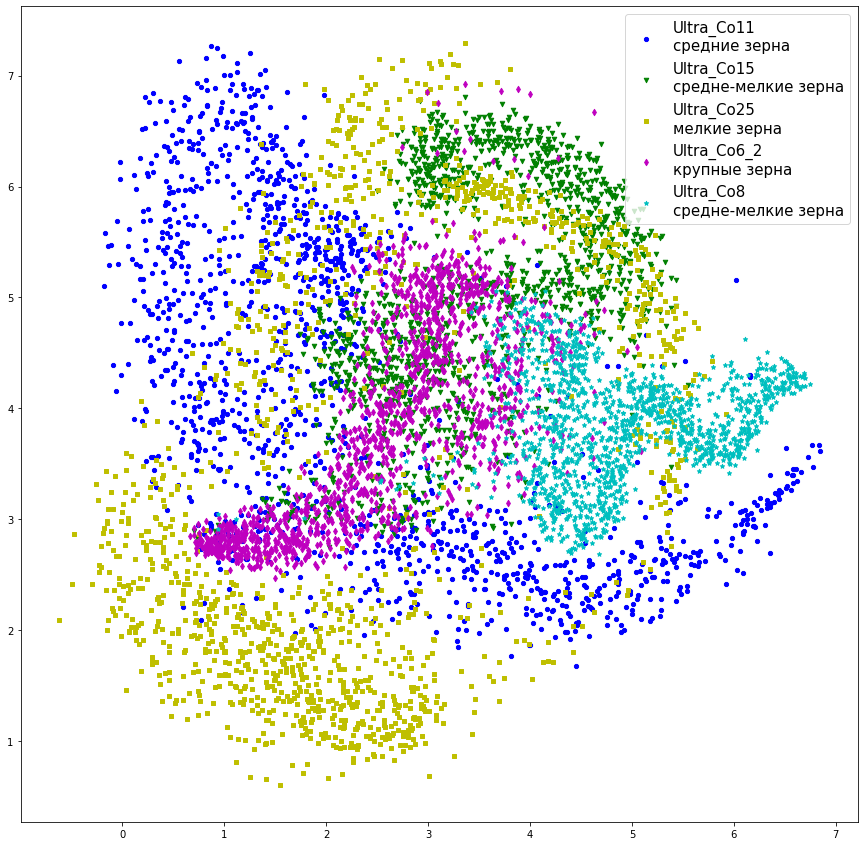

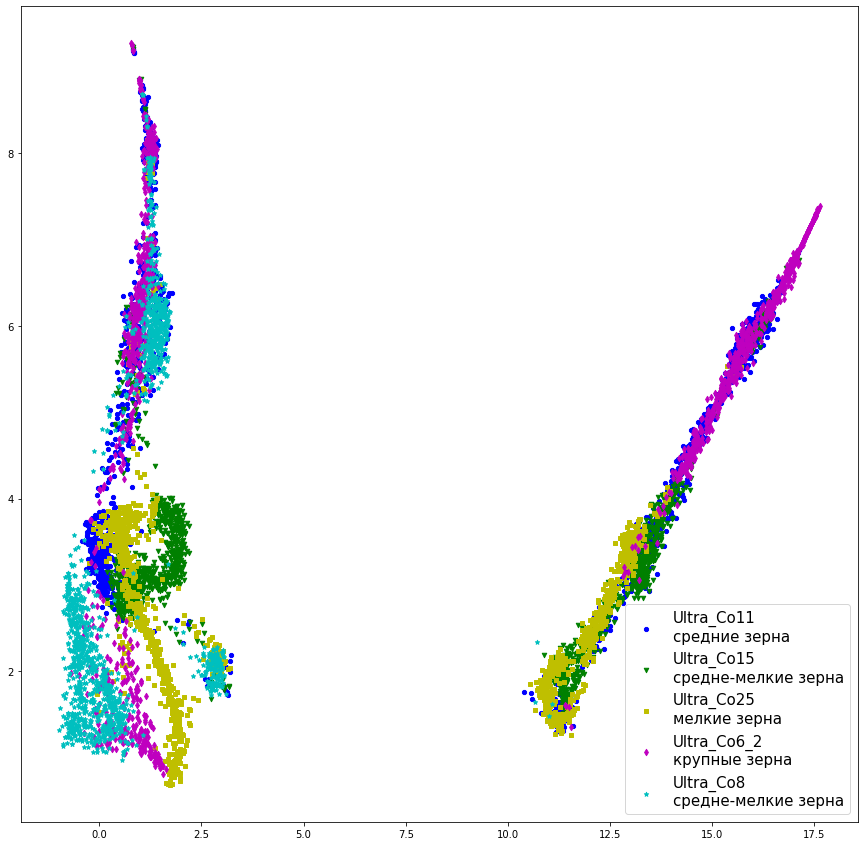

In [35]:
name_2=f'embs_space_seed={seed}_b_512_4x_360_emb_dim_1_n_embed_8192_sub_left'
name_1=f'embs_space_seed={seed}_t_512_4x_360_emb_dim_1_n_embed_8192_sub_left'
r_shape=(5,1440,2)

plot_2d_scatter(embs_scatter=umaped_vct_2d_t,legend=legend,r_shape=r_shape,save=True,name=name_1)
plot_2d_scatter(embs_scatter=umaped_vct_2d_b,legend=legend,r_shape=r_shape,save=True,name=name_2)

In [ ]:
mse_losses = []
ssim_losses = []

visual_loader = DataLoader(
    dataset, batch_size=1, num_workers=2
)

for i, (img, label) in enumerate(visual_loader):
    model.zero_grad()
    img = img.to(device)

    out, latent_loss = model(img)
    predicted_image = np.transpose(out.cpu().detach().numpy()[0])
    original_image = np.transpose(img.cpu().detach().numpy()[0])

    mse_losses.append(metrics.mean_squared_error(original_image, predicted_image))
    ssim_losses.append(metrics.structural_similarity(original_image, predicted_image, multichannel=True))

mse_losses = np.array(mse_losses)
ssim_losses = np.array(ssim_losses)

In [ ]:
df_mse=pd.DataFrame()
df_ssim=pd.DataFrame()


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

cnt = Counter(np.array(dataset.samples)[:, 1])

for i in cnt.keys():
    emb_number = cnt[i]
    key = int(i)

    start = 0
    for val in range(int(i)):
        start += cnt[str(val)]

    end = start + emb_number

    mse_y = mse_losses[start:end]
    ssim_y = ssim_losses[start:end]

    df_mse[names[key]]=pd.Series(mse_y)
    df_ssim[names[key]]=pd.Series(ssim_y)



plt.rcParams['font.size'] = '20'


# plt.ylabel('MSE loss', fontsize=20)
name = 'vq-vae-2'
# plt.savefig(f'mse_ssim_losses_{name}_512.png')

# plt.show()

In [ ]:
plt.rcParams['font.size'] = '15'
name = 'vq-vae-2'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
# plt.figure(figsize=(10,10))
df_ssim.boxplot(ax=ax2)
df_mse.boxplot(ax=ax1)

ax1.set_ylabel('MSE loss', fontsize=20)
ax2.set_ylabel('SSIM similarity', fontsize=20)

plt.savefig(f'mse_ssim_losses_{name}_512_boxplot.png')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

cnt = Counter(np.array(dataset.samples)[:, 1])

for i in cnt.keys():
    emb_number = cnt[i]
    key = int(i)

    start = 0
    for val in range(int(i)):
        start += cnt[str(val)]

    end = start + emb_number

    x = np.arange(mse_losses.shape[0])[start:end]
    mse_y = mse_losses[start:end]
    ssim_y = ssim_losses[start:end]

    # ax1.plot(x, mse_y)
    ax1.scatter(x, mse_y)

    # ax2.plot(x, ssim_y)
    ax2.scatter(x, ssim_y)

plt.rcParams['font.size'] = '20'

ax1.legend(names, fontsize=15)
ax1.set_title('MSE image losses', fontsize=20)
ax1.set_xlabel('image number', fontsize=20)
ax1.set_ylabel('MSE loss', fontsize=20)

ax2.legend(names, fontsize=15)
ax2.set_title('Structural image similarity', fontsize=20)
ax2.set_xlabel('image number', fontsize=20)
ax2.set_ylabel('SSIM similarity', fontsize=20)

name = 'vq-vae-2'
plt.savefig(f'mse_ssim_losses_{name}_512.png')

plt.show()

In [ ]:
def get_emb_distr(f_vects, projection_axis, step, eps):
    """
    :param step:
    :param f_vects: ndarray shape (classes_num,N,2)
    :param projection_axis:
    :param eps:
    :return:
    """

    axis_start = f_vects[0, :, projection_axis].min()
    axis_end = f_vects[0, :, projection_axis].max()

    for vects in f_vects:
        min_val = vects[:, projection_axis].min()
        max_val = vects[:, projection_axis].max()

        if min_val < axis_start:
            axis_start = min_val

        if max_val > axis_end:
            axis_end = max_val

    axis_step = step * (axis_end - axis_start)
    axis_eps = eps * (axis_end - axis_start)
    axis_vals = np.arange(axis_start, axis_end, axis_step)

    points_distr = []

    for i, vects in enumerate(f_vects):
        points_distr.append([])
        for axis_val in axis_vals:
            counter = 0
            for point in vects[:, projection_axis]:
                if abs(point - axis_val) <= axis_eps:
                    counter += 1
            points_distr[i].append(counter)

    for i, distr in enumerate(points_distr):
        points_distr[i] = np.array(points_distr[i]) / sum(distr)

    return axis_vals, np.array(points_distr), axis_step, axis_eps

In [ ]:
names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

title = 'VQ-VAE-2 embs projections'

ax1.set_title(f'{title}', fontsize=20)
ax1.set_xlabel('y val', fontsize=20)
ax1.set_ylabel('norm(count)', fontsize=20)

ax2.set_title(f'{title}', fontsize=20)
ax2.set_xlabel('x val', fontsize=20)
ax2.set_ylabel('norm(count)', fontsize=20)

step = 0.05
size = 4
# eps=step/2
eps = 0.2
projection_axis = 1

f_vects = umaped_vct_2d_b.reshape((5, 360, 2))

x_axis_vals, x_points_distr, x_step, x_eps = get_emb_distr(f_vects, projection_axis=0, step=step, eps=eps)
y_axis_vals, y_points_distr, y_step, y_eps = get_emb_distr(f_vects, projection_axis=1, step=step, eps=eps)

for i in range(len(x_points_distr)):
    ax1.plot(y_axis_vals, y_points_distr[i], color=colors[i])
    ax2.plot(x_axis_vals, x_points_distr[i], color=colors[i])


for i in range(len(x_points_distr)):
    # y projection
    ax1.scatter(y_axis_vals, y_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])

    # x prjection
    ax2.scatter(x_axis_vals, x_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])

ax1.legend(names + [
    f'шаг={round(y_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(y_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
           fontsize=15)
ax2.legend(names + [
    f'шаг={round(x_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(x_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
           fontsize=15)

plt.savefig(f'embs_projection_vq_vae_2_step={step}_eps={eps}.png')
plt.show()